# Compare neighbourhoods

In [1]:
library(SingleCellExperiment)
library(miloR)
library(DelayedArray)
library(Matrix)
source("../data-in/rabbit/load_rabbit.R")

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

## Load data

In [35]:
# Load data
r_data <- loadRabbitData()
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

In [36]:
reducedDim(r_data,"PCA") <- as.matrix(reducedDim(r_data,"PCA"))

In [25]:
m_data <- readRDS("../data-in/mouse/integrated_sce.rds")
m_data


class: SingleCellExperiment 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(0):
reducedDimNames(0):
altExpNames(0):

In [26]:
m_pcs <- readRDS("../data-in/mouse/integrated_corrected_pcs.rds")
reducedDim(m_data,"PCA") <- as.matrix(m_pcs)

In [27]:
m_meta <- read.table("../data-in/mouse/meta.tsv",sep="\t")
m_data$celltype <- m_meta$celltype.clustering

In [28]:
m_meta2 <- readRDS("../data-in/mouse/integrated_metadata.rds")
reducedDim(m_data,"UMAP") <- m_meta2[,c("BBKNN_UMAP1","BBKNN_UMAP2")]

In [28]:
orthologs <- read.table("../data-in/orthologs.tsv",sep="\t")
orthologs[1:5,]

,ref,query
,<chr>,<chr>
ENSOCUG00000000006,ENSOCUG00000000006,ENSMUSG00000026102
ENSOCUG00000000007,ENSOCUG00000000007,ENSMUSG00000028480
ENSOCUG00000000008,ENSOCUG00000000008,ENSMUSG00000070999
ENSOCUG00000000009,ENSOCUG00000000009,ENSMUSG00000028478
ENSOCUG00000000010,ENSOCUG00000000010,ENSMUSG00000028479


## Compute neighbourhoods

In [37]:
# Compute rabbit neighbourhoods
r_milo <- Milo(r_data)
r_milo <- buildGraph(r_milo, k=30, d=50, reduced.dim="PCA")
r_milo <- makeNhoods(r_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")


Constructing kNN graph with k:30

Checking valid object



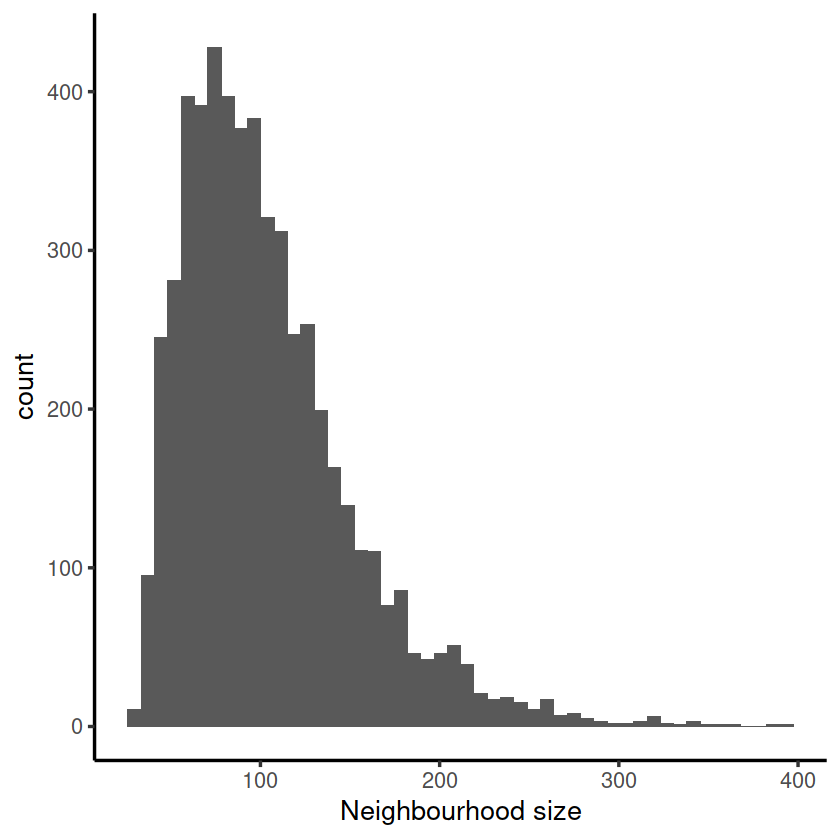

In [38]:
plotNhoodSizeHist(r_milo)

Warning message in plotNhoodGraph(r_milo):
“Coercing layout to matrix format”


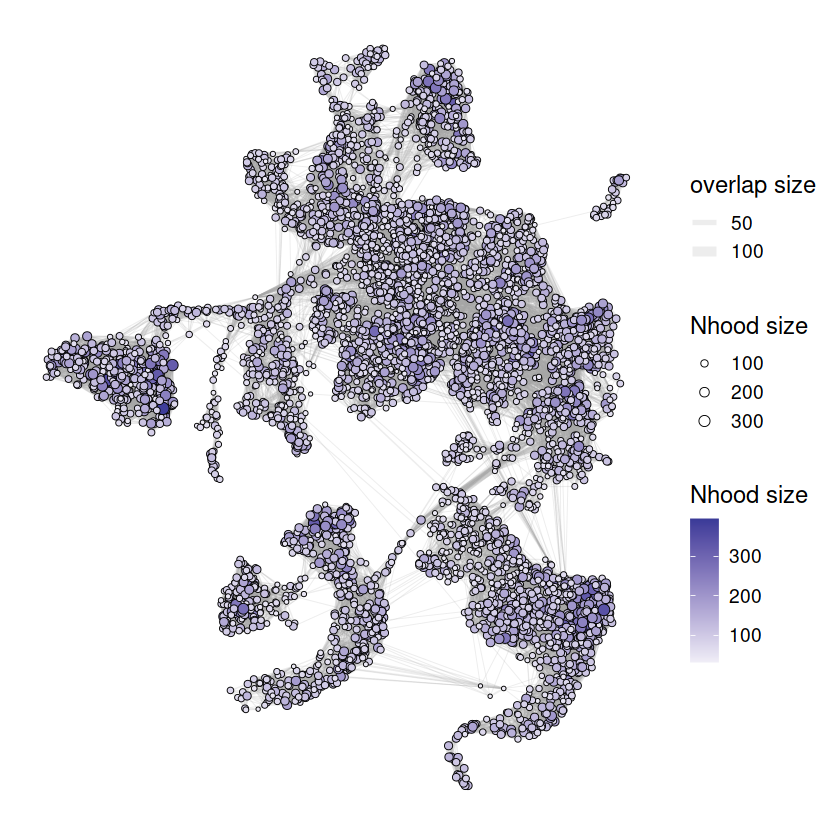

In [42]:
r_milo <- buildNhoodGraph(r_milo)
plotNhoodGraph(r_milo)

In [41]:
writeMM(r_milo@nhoods,"../data-out/compare_neighbourhoods/r_nhoods.mtx")
#saveRDS(r_milo,"../data-out/compare_neighbourhoods/r_milo.rds")

NULL

In [29]:
# Compute mouse neighbourhoods
m_milo <- Milo(m_data)
m_milo <- buildGraph(m_milo, k=30, d=50, reduced.dim="PCA")
m_milo <- makeNhoods(m_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")

Constructing kNN graph with k:30

Checking valid object



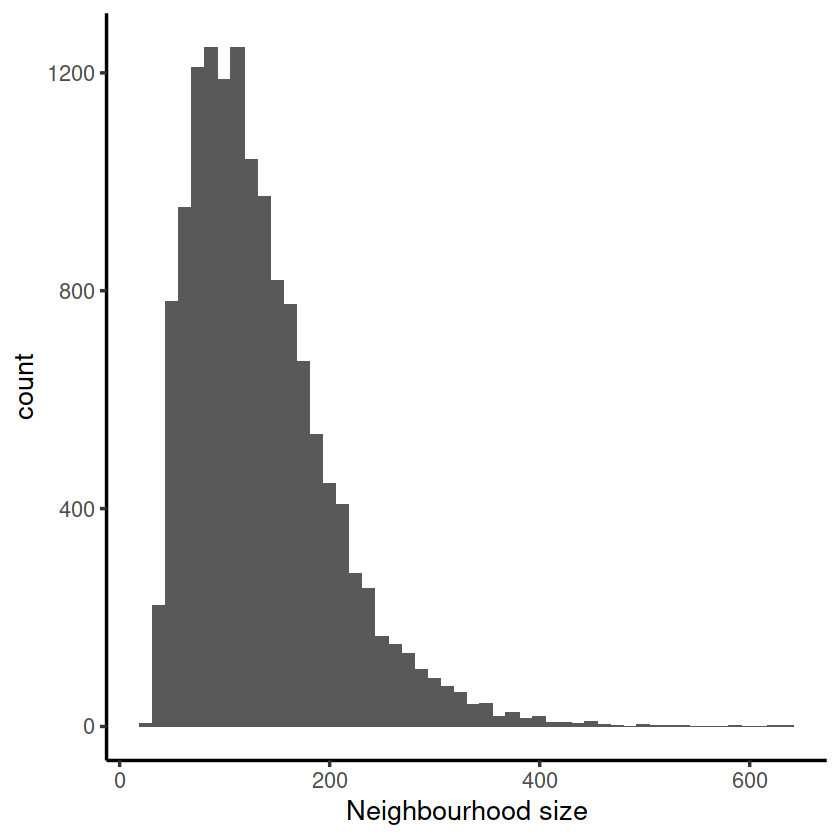

In [30]:
plotNhoodSizeHist(m_milo)

Warning message in plotNhoodGraph(m_milo):
“Coercing layout to matrix format”


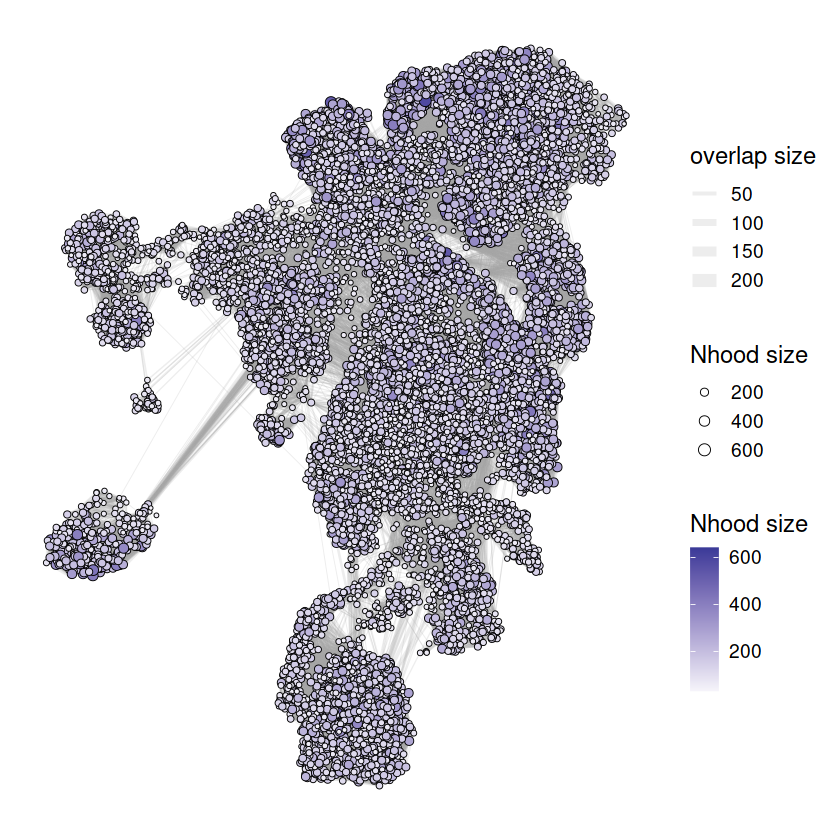

In [33]:
m_milo <- buildNhoodGraph(m_milo)
plotNhoodGraph(m_milo)

In [43]:
#m_milo <- readRDS("../data-out/compare_neighbourhoods/m_milo.rds")
#m_nhoods <- readRDS("../data-out/compare_neighbourhoods/m_nhoods.rds")
saveRDS(m_milo,"../data-out/compare_neighbourhoods/m_milo.rds")
#saveRDS(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.rds")
#writeMM(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.mtx")

## Plot similarity

In [48]:
# Load correlation
nhood_sim = fread("../data-out/compare_neighbourhoods/gspec_cor.tsv", sep="\t",data.table=F)

In [49]:
nhood_sim[1:5,1:5]

,V1,V2,V3,V4,V5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7028583,0.4118058,0.7519703,0.7523510,0.7310930
2,0.5681460,0.5262974,0.5828057,0.5611772,0.5690039
3,0.6076393,0.5157455,0.6452733,0.6088331,0.6284291
4,0.7170224,0.4221801,0.7401596,0.7356656,0.7117396
5,0.7067318,0.4039405,0.7611792,0.7728675,0.7352545


In [51]:
# Get maximum similarity for each rabbit neighbourhood
r_maxsim <- apply(nhood_sim,1,FUN=max)
m_maxsim <- apply(nhood_sim,2,FUN=max)

In [50]:
r_graph <- nhoodGraph(r_milo)
V(nh_graph)$colour_by <- max_cor
layout <- reducedDim(rabbit.milo, "UMAP")[as.numeric(vertex_attr(nhoodGraph(rabbit.milo))$name),]
p <- ggraph(simplify(nh_graph), layout = layout) +
  geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha=0.2) +
  geom_node_point(aes(fill = colour_by, size = size), shape=21) +
  scale_edge_width(range = c(0.2,3), name="overlap size") +
  theme_classic(base_size=14) +
  theme(axis.line = element_blank(), axis.text = element_blank(),
        axis.ticks = element_blank(), axis.title = element_blank(),
        aspect.ratio=1) +
  scale_fill_viridis()




list()

In [ ]:
  rabbit.align_pos <- rabbit.psuedocell[align_df$rabbit,]
  rabbit.align_pos$alignment <- align_df$name
  rabbit.align_pos$correlation <- align_df$correlation
  
  
  mouse.align_pos <- mouse.pseudocell[align_df$mouse,] 
  mouse.align_pos$alignment <- align_df$name
  mouse.align_pos$correlation <- align_df$correlation
  
  
  align_line_df <- rbind(rabbit.align_pos,mouse.align_pos)

+ geom_line(data=align_line_df,aes(group=alignment,alpha=0.1,colour=correlation))